In [1]:
from torchsummary import summary
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import time, os, random
import pickle
from my_utils.cosmo_loader import  kids450_files_cluster, regr_Kids450
from my_utils.cosmo_collate import cosmotrain_collate_fn
from torch.utils.data import Dataset, DataLoader
from my_utils.models import Regression_model, Regression_model_2
from torchvision import datasets, transforms, models

In [2]:
from my_utils.real_resnets import Resnet_regressionmodel, Resnet_pretrainingmodel, DSModel

In [3]:
from torchsummary import summary
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import time, os, random
import pickle
from my_utils.cosmo_loader import  kids450_files_cluster, regr_Kids450
from my_utils.cosmo_collate import cosmotrain_collate_fn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from scipy.spatial import ConvexHull
import pickle
import matplotlib.animation as animation
#import IPython
#from IPython.display import HTML
#%matplotlib notebook

In [4]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available, using CPU.")

GPU is available.


In [5]:
#file_paths
file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 192
resolution = 128
train_data = regr_Kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
valid_data = regr_Kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
test_data =  regr_Kids450(phase = "test",file_paths = file_paths_test,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)
kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)

print(f'Length of test data: {len(test_data)}')

Length of test data: 114000


In [6]:
def get_model_checkpoints(run_name):
    """
    Function that returns all the available runs with different epochs with strings .pt
    args:
    """
    print(run_name)
    model_dir = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    run_name_w_prefix = run_name + "_epoch_"
    suffix = ".pt"
    
    all_files = os.listdir(model_dir)
    
    #get the matching files
    model_files = [f for f in all_files if f.startswith(run_name_w_prefix) and f.endswith(suffix)] 
    
    # Sort the files by epoch number if needed
    model_files.sort(key=lambda x: int(x[len(run_name_w_prefix):-len(suffix)]))
    
    return model_files
def get_truegrid():
    truegrid_array = torch.empty((57,2))
    for i, file in tqdm(enumerate(file_paths_test), desc="Processing files"):
        with h5py.File(file, 'r') as file:
            
            #get the labels from the h5 file
            truegrid_array[i] = torch.tensor(file["labels"][0])
    return truegrid_array
#standardize
#get the statistics:
import pickle
def data_stats_dict():
    pickle_file_path = "/cluster/work/refregier/atepper/kids_450/full_data/kids450_test_stats.pkl"
    # Open the pickle file and load the data
    with open(pickle_file_path, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

def data_stats_dict():
    pickle_file_path = "/cluster/work/refregier/atepper/kids_450/full_data/kids450_test_stats.pkl"
    # Open the pickle file and load the data
    with open(pickle_file_path, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict    
def un_standardize(omega_m, sigma_8):
    
    data_dict = data_stats_dict()
    mean_labels = data_dict["mean_labels"].numpy()
    std_dev_labels = data_dict["label_std_deviation"].numpy()
    
    
    omega_m = (omega_m * std_dev_labels[0]) + mean_labels[0]
    sigma_8 = (sigma_8 * std_dev_labels[1]) + mean_labels[1]
    
    return omega_m, sigma_8

def get_predictions(model, dataloader, device='cpu'):
    #set model to eval mode
    model.eval()
    true_values_omega_m = []
    true_values_sigma_8 = []
    pred_values_omega_m = []
    pred_values_sigma_8 = []
    with torch.no_grad():  # No need to compute gradients
        for i, (images,labels_true) in tqdm(enumerate(dataloader), desc="Processing data"):
            #print(i)
            images = images.squeeze().to(device).float()
            labels_true = labels_true.squeeze().to(device).float()
            labels_pred = model(images)
            
            pred_omega_m, pred_sigma_8 = labels_pred[:, 0], labels_pred[:, 1]
            true_omega_m, true_sigma_8 = labels_true[:, 0], labels_true[:, 1]
            
            true_values_omega_m.extend(true_omega_m.cpu().numpy())
            true_values_sigma_8.extend(true_sigma_8.cpu().numpy())
            pred_values_omega_m.extend(pred_omega_m.cpu().numpy())
            pred_values_sigma_8.extend(pred_sigma_8.cpu().numpy())
            #if i == 2:
            #    print("done")
            #    break
                
    return (np.array(true_values_omega_m), np.array(pred_values_omega_m)), \
           (np.array(true_values_sigma_8), np.array(pred_values_sigma_8))


#(true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)

In [7]:
def load_checkpoint(model,run_path,run_name):
    """
    Load the model
    Returns:
    model : PreModel : model
    optimizer : torch.optim.Optimizer : optimizer
    scheduler : torch.optim.lr_scheduler : scheduler
    """
    #load_path = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    #run_name = "Kids_450_regrsimclr_full_test_epoch_100.pt"
    out = os.path.join(run_path ,run_name)
    checkpoint = torch.load(out)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [8]:
def run_inference(model, run_name,epochs):
    true_omega_m_list = []
    true_sigma_8_list = []
    pred_omega_m_list = []
    pred_sigma_8_list = []    
    #get model checkpoints
    model_checkpoints = get_model_checkpoints(run_name)
    run_path = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    #print(model_checkpoints)
    for i,run_name in enumerate(model_checkpoints):
        model = load_checkpoint(model, run_path ,run_name)
        
        #get predictions
        (true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)
        #unstandardize the data
        unstd_pred_omega_m, unstd_pred_sigma_8 = un_standardize(pred_omega_m ,pred_sigma_8)
        
        true_omega_m_list.append(true_omega_m)
        pred_omega_m_list.append(unstd_pred_omega_m)
        true_sigma_8_list.append(true_sigma_8)
        pred_sigma_8_list.append(unstd_pred_sigma_8)
        
    return true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list

In [28]:
#the one with big Lr and nonlinear dropout
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_downstream_smaller_lr"
epochs = list(range(start_epoch,end_epoch+1))
model = Resnet_regressionmodel('resnet18',pretrained_weights = False,dropout_rate = 0.4,head_type = "nonlinear").to('cuda:0')
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Kids_450_downstream_smaller_lr


RuntimeError: Error(s) in loading state_dict for Resnet_regressionmodel:
	Missing key(s) in state_dict: "pretrained.conv1.weight", "pretrained.bn1.weight", "pretrained.bn1.bias", "pretrained.bn1.running_mean", "pretrained.bn1.running_var", "pretrained.layer1.0.conv1.weight", "pretrained.layer1.0.bn1.weight", "pretrained.layer1.0.bn1.bias", "pretrained.layer1.0.bn1.running_mean", "pretrained.layer1.0.bn1.running_var", "pretrained.layer1.0.conv2.weight", "pretrained.layer1.0.bn2.weight", "pretrained.layer1.0.bn2.bias", "pretrained.layer1.0.bn2.running_mean", "pretrained.layer1.0.bn2.running_var", "pretrained.layer1.1.conv1.weight", "pretrained.layer1.1.bn1.weight", "pretrained.layer1.1.bn1.bias", "pretrained.layer1.1.bn1.running_mean", "pretrained.layer1.1.bn1.running_var", "pretrained.layer1.1.conv2.weight", "pretrained.layer1.1.bn2.weight", "pretrained.layer1.1.bn2.bias", "pretrained.layer1.1.bn2.running_mean", "pretrained.layer1.1.bn2.running_var", "pretrained.layer2.0.conv1.weight", "pretrained.layer2.0.bn1.weight", "pretrained.layer2.0.bn1.bias", "pretrained.layer2.0.bn1.running_mean", "pretrained.layer2.0.bn1.running_var", "pretrained.layer2.0.conv2.weight", "pretrained.layer2.0.bn2.weight", "pretrained.layer2.0.bn2.bias", "pretrained.layer2.0.bn2.running_mean", "pretrained.layer2.0.bn2.running_var", "pretrained.layer2.0.downsample.0.weight", "pretrained.layer2.0.downsample.1.weight", "pretrained.layer2.0.downsample.1.bias", "pretrained.layer2.0.downsample.1.running_mean", "pretrained.layer2.0.downsample.1.running_var", "pretrained.layer2.1.conv1.weight", "pretrained.layer2.1.bn1.weight", "pretrained.layer2.1.bn1.bias", "pretrained.layer2.1.bn1.running_mean", "pretrained.layer2.1.bn1.running_var", "pretrained.layer2.1.conv2.weight", "pretrained.layer2.1.bn2.weight", "pretrained.layer2.1.bn2.bias", "pretrained.layer2.1.bn2.running_mean", "pretrained.layer2.1.bn2.running_var", "pretrained.layer3.0.conv1.weight", "pretrained.layer3.0.bn1.weight", "pretrained.layer3.0.bn1.bias", "pretrained.layer3.0.bn1.running_mean", "pretrained.layer3.0.bn1.running_var", "pretrained.layer3.0.conv2.weight", "pretrained.layer3.0.bn2.weight", "pretrained.layer3.0.bn2.bias", "pretrained.layer3.0.bn2.running_mean", "pretrained.layer3.0.bn2.running_var", "pretrained.layer3.0.downsample.0.weight", "pretrained.layer3.0.downsample.1.weight", "pretrained.layer3.0.downsample.1.bias", "pretrained.layer3.0.downsample.1.running_mean", "pretrained.layer3.0.downsample.1.running_var", "pretrained.layer3.1.conv1.weight", "pretrained.layer3.1.bn1.weight", "pretrained.layer3.1.bn1.bias", "pretrained.layer3.1.bn1.running_mean", "pretrained.layer3.1.bn1.running_var", "pretrained.layer3.1.conv2.weight", "pretrained.layer3.1.bn2.weight", "pretrained.layer3.1.bn2.bias", "pretrained.layer3.1.bn2.running_mean", "pretrained.layer3.1.bn2.running_var", "pretrained.layer4.0.conv1.weight", "pretrained.layer4.0.bn1.weight", "pretrained.layer4.0.bn1.bias", "pretrained.layer4.0.bn1.running_mean", "pretrained.layer4.0.bn1.running_var", "pretrained.layer4.0.conv2.weight", "pretrained.layer4.0.bn2.weight", "pretrained.layer4.0.bn2.bias", "pretrained.layer4.0.bn2.running_mean", "pretrained.layer4.0.bn2.running_var", "pretrained.layer4.0.downsample.0.weight", "pretrained.layer4.0.downsample.1.weight", "pretrained.layer4.0.downsample.1.bias", "pretrained.layer4.0.downsample.1.running_mean", "pretrained.layer4.0.downsample.1.running_var", "pretrained.layer4.1.conv1.weight", "pretrained.layer4.1.bn1.weight", "pretrained.layer4.1.bn1.bias", "pretrained.layer4.1.bn1.running_mean", "pretrained.layer4.1.bn1.running_var", "pretrained.layer4.1.conv2.weight", "pretrained.layer4.1.bn2.weight", "pretrained.layer4.1.bn2.bias", "pretrained.layer4.1.bn2.running_mean", "pretrained.layer4.1.bn2.running_var", "projector.layers.0.linear.weight", "projector.layers.0.bn.weight", "projector.layers.0.bn.bias", "projector.layers.0.bn.running_mean", "projector.layers.0.bn.running_var", "projector.layers.2.linear.weight", "projector.layers.2.bn.weight", "projector.layers.2.bn.bias", "projector.layers.2.bn.running_mean", "projector.layers.2.bn.running_var". 
	Unexpected key(s) in state_dict: "premodel.pretrained.conv1.weight", "premodel.pretrained.bn1.weight", "premodel.pretrained.bn1.bias", "premodel.pretrained.bn1.running_mean", "premodel.pretrained.bn1.running_var", "premodel.pretrained.bn1.num_batches_tracked", "premodel.pretrained.layer1.0.conv1.weight", "premodel.pretrained.layer1.0.bn1.weight", "premodel.pretrained.layer1.0.bn1.bias", "premodel.pretrained.layer1.0.bn1.running_mean", "premodel.pretrained.layer1.0.bn1.running_var", "premodel.pretrained.layer1.0.bn1.num_batches_tracked", "premodel.pretrained.layer1.0.conv2.weight", "premodel.pretrained.layer1.0.bn2.weight", "premodel.pretrained.layer1.0.bn2.bias", "premodel.pretrained.layer1.0.bn2.running_mean", "premodel.pretrained.layer1.0.bn2.running_var", "premodel.pretrained.layer1.0.bn2.num_batches_tracked", "premodel.pretrained.layer1.1.conv1.weight", "premodel.pretrained.layer1.1.bn1.weight", "premodel.pretrained.layer1.1.bn1.bias", "premodel.pretrained.layer1.1.bn1.running_mean", "premodel.pretrained.layer1.1.bn1.running_var", "premodel.pretrained.layer1.1.bn1.num_batches_tracked", "premodel.pretrained.layer1.1.conv2.weight", "premodel.pretrained.layer1.1.bn2.weight", "premodel.pretrained.layer1.1.bn2.bias", "premodel.pretrained.layer1.1.bn2.running_mean", "premodel.pretrained.layer1.1.bn2.running_var", "premodel.pretrained.layer1.1.bn2.num_batches_tracked", "premodel.pretrained.layer2.0.conv1.weight", "premodel.pretrained.layer2.0.bn1.weight", "premodel.pretrained.layer2.0.bn1.bias", "premodel.pretrained.layer2.0.bn1.running_mean", "premodel.pretrained.layer2.0.bn1.running_var", "premodel.pretrained.layer2.0.bn1.num_batches_tracked", "premodel.pretrained.layer2.0.conv2.weight", "premodel.pretrained.layer2.0.bn2.weight", "premodel.pretrained.layer2.0.bn2.bias", "premodel.pretrained.layer2.0.bn2.running_mean", "premodel.pretrained.layer2.0.bn2.running_var", "premodel.pretrained.layer2.0.bn2.num_batches_tracked", "premodel.pretrained.layer2.0.downsample.0.weight", "premodel.pretrained.layer2.0.downsample.1.weight", "premodel.pretrained.layer2.0.downsample.1.bias", "premodel.pretrained.layer2.0.downsample.1.running_mean", "premodel.pretrained.layer2.0.downsample.1.running_var", "premodel.pretrained.layer2.0.downsample.1.num_batches_tracked", "premodel.pretrained.layer2.1.conv1.weight", "premodel.pretrained.layer2.1.bn1.weight", "premodel.pretrained.layer2.1.bn1.bias", "premodel.pretrained.layer2.1.bn1.running_mean", "premodel.pretrained.layer2.1.bn1.running_var", "premodel.pretrained.layer2.1.bn1.num_batches_tracked", "premodel.pretrained.layer2.1.conv2.weight", "premodel.pretrained.layer2.1.bn2.weight", "premodel.pretrained.layer2.1.bn2.bias", "premodel.pretrained.layer2.1.bn2.running_mean", "premodel.pretrained.layer2.1.bn2.running_var", "premodel.pretrained.layer2.1.bn2.num_batches_tracked", "premodel.pretrained.layer3.0.conv1.weight", "premodel.pretrained.layer3.0.bn1.weight", "premodel.pretrained.layer3.0.bn1.bias", "premodel.pretrained.layer3.0.bn1.running_mean", "premodel.pretrained.layer3.0.bn1.running_var", "premodel.pretrained.layer3.0.bn1.num_batches_tracked", "premodel.pretrained.layer3.0.conv2.weight", "premodel.pretrained.layer3.0.bn2.weight", "premodel.pretrained.layer3.0.bn2.bias", "premodel.pretrained.layer3.0.bn2.running_mean", "premodel.pretrained.layer3.0.bn2.running_var", "premodel.pretrained.layer3.0.bn2.num_batches_tracked", "premodel.pretrained.layer3.0.downsample.0.weight", "premodel.pretrained.layer3.0.downsample.1.weight", "premodel.pretrained.layer3.0.downsample.1.bias", "premodel.pretrained.layer3.0.downsample.1.running_mean", "premodel.pretrained.layer3.0.downsample.1.running_var", "premodel.pretrained.layer3.0.downsample.1.num_batches_tracked", "premodel.pretrained.layer3.1.conv1.weight", "premodel.pretrained.layer3.1.bn1.weight", "premodel.pretrained.layer3.1.bn1.bias", "premodel.pretrained.layer3.1.bn1.running_mean", "premodel.pretrained.layer3.1.bn1.running_var", "premodel.pretrained.layer3.1.bn1.num_batches_tracked", "premodel.pretrained.layer3.1.conv2.weight", "premodel.pretrained.layer3.1.bn2.weight", "premodel.pretrained.layer3.1.bn2.bias", "premodel.pretrained.layer3.1.bn2.running_mean", "premodel.pretrained.layer3.1.bn2.running_var", "premodel.pretrained.layer3.1.bn2.num_batches_tracked", "premodel.pretrained.layer4.0.conv1.weight", "premodel.pretrained.layer4.0.bn1.weight", "premodel.pretrained.layer4.0.bn1.bias", "premodel.pretrained.layer4.0.bn1.running_mean", "premodel.pretrained.layer4.0.bn1.running_var", "premodel.pretrained.layer4.0.bn1.num_batches_tracked", "premodel.pretrained.layer4.0.conv2.weight", "premodel.pretrained.layer4.0.bn2.weight", "premodel.pretrained.layer4.0.bn2.bias", "premodel.pretrained.layer4.0.bn2.running_mean", "premodel.pretrained.layer4.0.bn2.running_var", "premodel.pretrained.layer4.0.bn2.num_batches_tracked", "premodel.pretrained.layer4.0.downsample.0.weight", "premodel.pretrained.layer4.0.downsample.1.weight", "premodel.pretrained.layer4.0.downsample.1.bias", "premodel.pretrained.layer4.0.downsample.1.running_mean", "premodel.pretrained.layer4.0.downsample.1.running_var", "premodel.pretrained.layer4.0.downsample.1.num_batches_tracked", "premodel.pretrained.layer4.1.conv1.weight", "premodel.pretrained.layer4.1.bn1.weight", "premodel.pretrained.layer4.1.bn1.bias", "premodel.pretrained.layer4.1.bn1.running_mean", "premodel.pretrained.layer4.1.bn1.running_var", "premodel.pretrained.layer4.1.bn1.num_batches_tracked", "premodel.pretrained.layer4.1.conv2.weight", "premodel.pretrained.layer4.1.bn2.weight", "premodel.pretrained.layer4.1.bn2.bias", "premodel.pretrained.layer4.1.bn2.running_mean", "premodel.pretrained.layer4.1.bn2.running_var", "premodel.pretrained.layer4.1.bn2.num_batches_tracked", "premodel.projector.layers.0.linear.weight", "premodel.projector.layers.0.bn.weight", "premodel.projector.layers.0.bn.bias", "premodel.projector.layers.0.bn.running_mean", "premodel.projector.layers.0.bn.running_var", "premodel.projector.layers.0.bn.num_batches_tracked", "premodel.projector.layers.2.linear.weight", "premodel.projector.layers.2.bn.weight", "premodel.projector.layers.2.bn.bias", "premodel.projector.layers.2.bn.running_mean", "premodel.projector.layers.2.bn.running_var", "premodel.projector.layers.2.bn.num_batches_tracked", "ds_projector.layers.0.linear.weight", "ds_projector.layers.0.bn.weight", "ds_projector.layers.0.bn.bias", "ds_projector.layers.0.bn.running_mean", "ds_projector.layers.0.bn.running_var", "ds_projector.layers.0.bn.num_batches_tracked", "ds_projector.layers.2.linear.weight", "ds_projector.layers.2.bn.weight", "ds_projector.layers.2.bn.bias", "ds_projector.layers.2.bn.running_mean", "ds_projector.layers.2.bn.running_var", "ds_projector.layers.2.bn.num_batches_tracked". 

In [17]:
true_omega_m_list

[]

In [39]:
#the one with snall Lr and nonlinear head
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_real_resnet34_small"
epochs = list(range(start_epoch,end_epoch+1))
#model = Resnet_regressionmodel('resnet34',pretrained_weights = False ,head_type = "nonlinear").to('cuda:0')
model = Regression_model(layers = [3,4,6,3], head_type = "nonlinear" ,hidden_channels= 128).to("cuda")

#model = Regression_model(layers = [3,4,6,3], head_type = "nonlinear_dropout" ,hidden_channels= 128).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Processing data: 593it [00:29, 19.98it/s]
Processing data: 593it [00:29, 19.86it/s]
Processing data: 593it [00:30, 19.71it/s]
Processing data: 593it [00:31, 19.06it/s]
Processing data: 593it [00:30, 19.70it/s]
Processing data: 593it [00:30, 19.54it/s]
Processing data: 593it [00:30, 19.35it/s]
Processing data: 593it [00:31, 18.89it/s]
Processing data: 593it [00:30, 19.40it/s]
Processing data: 593it [00:30, 19.64it/s]
Processing data: 593it [00:30, 19.46it/s]
Processing data: 593it [00:30, 19.38it/s]
Processing data: 593it [00:30, 19.28it/s]
Processing data: 593it [00:30, 19.63it/s]
Processing data: 593it [00:30, 19.50it/s]
Processing data: 593it [00:30, 19.28it/s]
Processing data: 593it [00:31, 19.10it/s]
Processing data: 593it [00:30, 19.33it/s]
Processing data: 593it [00:30, 19.60it/s]
Processing data: 593it [00:30, 19.59it/s]
Processing data: 593it [00:29, 19.79it/s]


In [23]:
#the one with smaller channels and 
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_smaller_channels_dropout"
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [3,4,6,3], head_type = "nonlinear_dropout" ,hidden_channels= 128).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Processing data: 593it [00:30, 19.73it/s]
Processing data: 593it [00:29, 20.03it/s]
Processing data: 593it [00:29, 19.87it/s]
Processing data: 593it [00:29, 19.78it/s]
Processing data: 593it [00:31, 18.79it/s]
Processing data: 593it [00:30, 19.55it/s]
Processing data: 593it [00:30, 19.61it/s]
Processing data: 593it [00:30, 19.54it/s]
Processing data: 593it [00:30, 19.46it/s]
Processing data: 593it [00:30, 19.40it/s]
Processing data: 593it [00:30, 19.37it/s]
Processing data: 593it [00:30, 19.47it/s]
Processing data: 593it [00:30, 19.62it/s]
Processing data: 593it [00:30, 19.14it/s]
Processing data: 593it [00:30, 19.37it/s]
Processing data: 593it [00:30, 19.35it/s]
Processing data: 593it [00:30, 19.56it/s]
Processing data: 593it [00:30, 19.68it/s]
Processing data: 593it [00:30, 19.34it/s]
Processing data: 593it [00:30, 19.40it/s]
Processing data: 593it [00:30, 19.48it/s]


In [ ]:
start_epoch = 1
end_epoch = 150
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [2,3,3,2,1,1], head_type= "nonlinear",hidden_channels= 64 ).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

In [19]:
start_epoch = 1
end_epoch = 140
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [2,3,3,2], head_type= "linear",hidden_channels= 256 ).to("cuda")
run_name = "Kids_450_new_build"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Processing data: 593it [00:30, 19.62it/s]
Processing data: 593it [00:24, 24.59it/s]
Processing data: 593it [00:24, 24.51it/s]
Processing data: 593it [00:26, 22.59it/s]
Processing data: 593it [00:24, 23.94it/s]
Processing data: 593it [00:24, 24.17it/s]
Processing data: 593it [00:24, 23.81it/s]
Processing data: 593it [00:25, 22.89it/s]
Processing data: 593it [00:25, 23.54it/s]
Processing data: 593it [00:25, 23.31it/s]
Processing data: 593it [00:25, 23.09it/s]
Processing data: 593it [00:24, 23.98it/s]
Processing data: 593it [00:26, 22.51it/s]
Processing data: 593it [00:24, 24.11it/s]


In [30]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    ax.clear()
    ax.set_xlim(0.05, 0.5)  # Adjust the limits according to your data
    ax.set_ylim(0.4, 1.4)  # Adjust the limits according to your data
    ax.set_title(f"Resnet 34 Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel(r'$\Omega_m$',fontsize = 20)
    ax.set_ylabel(r'$\sigma_8$',fontsize = 20)
    #plt.xlabel(r'$\Omega_m$',fontsize = 20)
    #plt.ylabel(r'$\sigma_8$',fontsize = 20)

    
    # Plot scatter points for the current step
    sns.scatterplot(x=parameter1_data[frame], y=parameter2_data[frame], ax=ax)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="red", marker="o", s= 30)

        # Add text annotation for epoch
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + ".gif", writer='imagemagick')

# Display the animation
plt.show()

Processing files: 57it [00:04, 14.13it/s]


In [31]:
def start_stop(file_nr):
    file_nr -= 1 #due to starting index of pyth
    start = file_nr *2000
    end = start + 2000
    return start, end, file_nr

In [16]:
start, end,file_nr = start_stop(file_nr = 4)
print(start, end)

6000 8000


88000 90000


Processing files: 57it [00:00, 517.15it/s]


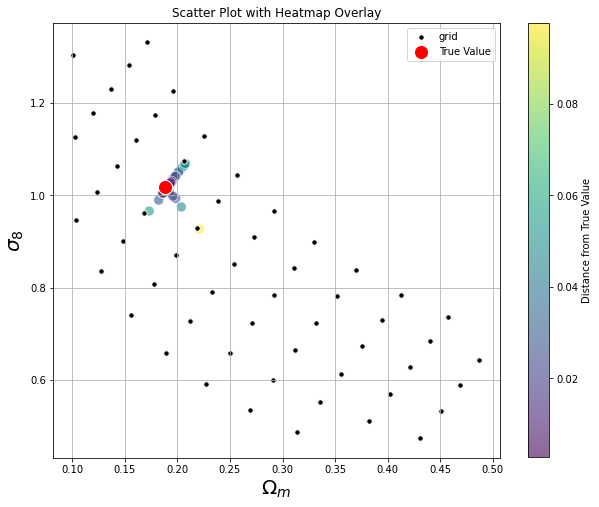

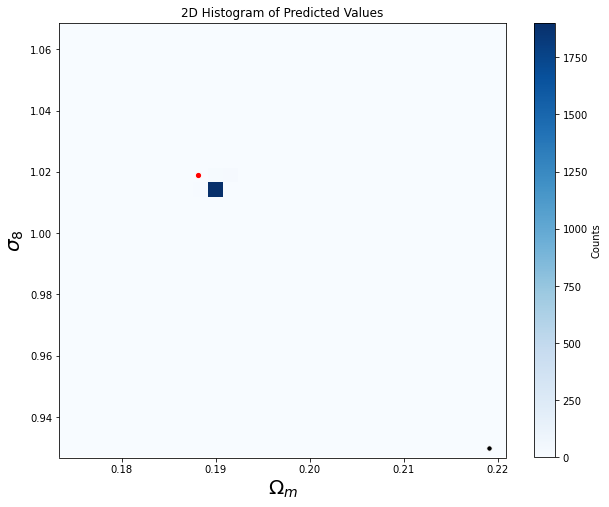

In [34]:
#in the test data every parameter is concurrent 2000 elements
epoch = 14
#start = 0
#stop = 2000
start, stop, file_index = start_stop(file_nr = 45)
print(start,stop)
pred_omega_m = pred_omega_m_list[epoch][start:stop]
pred_sigma_8 = pred_sigma_8_list[epoch][start:stop]
true_omega_m = true_omega_m_list[epoch][start:stop][0]
#print(true_omega_m_list[epoch])
true_sigma_8 = true_sigma_8_list[epoch][start:stop][0]

distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pred_omega_m, pred_sigma_8, c=distances, cmap='viridis', s=100, alpha=0.6, edgecolor='w')

# Add color bar to show the distance scale
cbar = plt.colorbar(scatter)
cbar.set_label('Distance from True Value')

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Plot the true value point
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=200, label='True Value', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 
#plt.xlim(0.05, 0.5)  # Adjust the limits according to your data
#plt.ylim(0.4, 1.4) 
plt.title('Scatter Plot with Heatmap Overlay')
plt.legend()
plt.grid(True)



# Show the plot
plt.show()

# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[30, 30], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')
#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

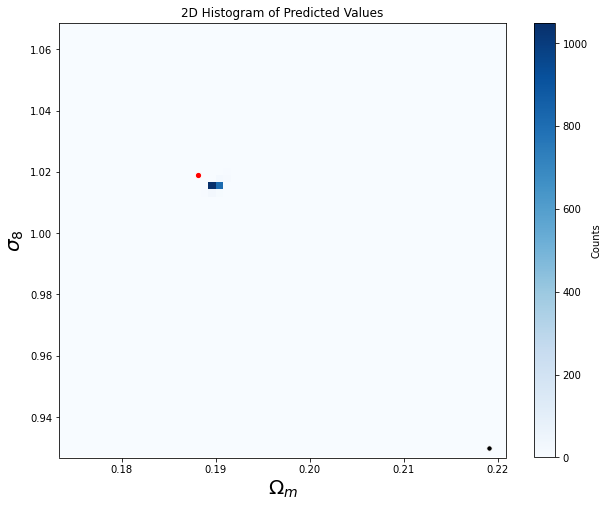

In [35]:
# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.cla()
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')

plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

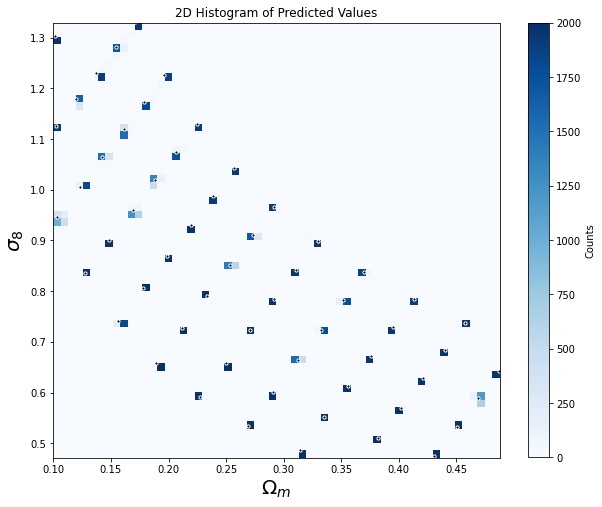

In [36]:
# Create 2D histogram
x = pred_omega_m_list[epoch]
y = pred_sigma_8_list[epoch]
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=10, label='grid', edgecolor='w')

# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)


plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

Processing files: 57it [00:00, 591.69it/s]


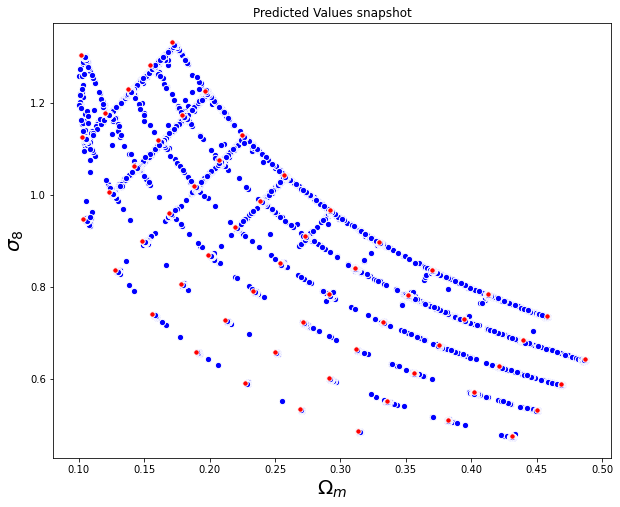

In [37]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


#in the test data every parameter is concurrent 2000 elements
#epoch = 1
pred_omega_m = pred_omega_m_list[epoch]
pred_sigma_8 = pred_sigma_8_list[epoch]


plt.figure(figsize=(10, 8))


truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Add color bar to show scale
plt.scatter(pred_omega_m, pred_sigma_8, c='blue', s=40, label='True Value', edgecolor='w')
plt.scatter(grid_omega_m, grid_sigma_8, c='red', s=30, label='grid', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('Predicted Values snapshot')

# Show plot
plt.show()

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
#in the test data every parameter is concurrent 2000 elements
start, stop, file_index = start_stop(file_nr = 8)
# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2
true_omega_m = true_omega_m_list[epoch][0]
true_sigma_8 = true_sigma_8_list[epoch][0]

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    pred_omega_m = parameter1_data[frame][start:stop]
    pred_sigma_8 = parameter2_data[frame][start:stop]
    true_omega_m = true_omega_m_list[frame][start:stop][0]
    true_sigma_8 = true_sigma_8_list[frame][start:stop][0]
    distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)
    
    #print(distances.shape)
    
    ax.clear()
    ax.set_xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
    ax.set_ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2)  # Adjust the limits according to your data
    ax.set_title(f"Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel('Omega_m')
    ax.set_ylabel('sigma_8')
    
    
    # Plot scatter points for the current step
    sns.scatterplot(x=pred_omega_m, y=pred_sigma_8, hue = distances ,ax=ax)
    #sns.heatmap(distances, ax=ax, cmap="viridis", cbar=True, alpha=0.6, annot=True)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="black", marker="o", s= 15)
    sns.scatterplot(x=true_omega_m_list[frame][start:stop], y=true_sigma_8_list[frame][start:stop] , ax=ax, color="red", marker="o", s= 30)
    
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.text(0.65, 0.95,f'True: omega_m: {true_omega_m:.2f}, sigma_8: {true_sigma_8:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')
plt.show()

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + "one_param_mse" + ".gif", writer='imagemagick')


Processing files: 57it [00:00, 216.85it/s]


In [24]:
prices = [7,1,5,3,6,4]
prices.index(4)
len(prices)

6

In [16]:
print("hello")

hello


The plots for downstram model with pretraining. I have to load the whole set. First the pretraining part, then infuse it with downstream and then i can load the checkpoints.


In [ ]:
pretrained_model = Resnet_pretrainingmodel('resnet34_simclr',
                               pretrained_weights = False, #these are the resnet weights
                               dropout_rate = 0.2, 
                               head_type = "nonlinear").to('cuda:0')
model = DSModel(pretrained_model,
               base_model = "resnet34",
               dropout_rate = 0.2,
               head_type = "nonlinear_dropout").to('cuda:0')
#the one with big Lr and nonlinear dropout
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_ds_resnet34_nonlinear_dropout_02_06"
epochs = list(range(start_epoch,end_epoch+1))
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Kids_450_ds_resnet34_nonlinear_dropout_02_06


Processing data: 593it [00:33, 17.81it/s]
Processing data: 593it [00:33, 17.63it/s]
Processing data: 593it [00:33, 17.84it/s]
Processing data: 593it [00:32, 17.97it/s]
Processing data: 593it [00:32, 17.97it/s]
Processing data: 593it [00:33, 17.75it/s]
Processing data: 593it [00:33, 17.81it/s]
Processing data: 593it [00:33, 17.76it/s]
Processing data: 593it [00:33, 17.47it/s]
Processing data: 593it [00:34, 17.40it/s]
Processing data: 593it [00:34, 17.21it/s]
Processing data: 593it [00:33, 17.47it/s]
Processing data: 36it [00:02, 17.33it/s]

In [19]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    ax.clear()
    ax.set_xlim(0.05, 0.5)  # Adjust the limits according to your data
    ax.set_ylim(0.4, 1.4)  # Adjust the limits according to your data
    ax.set_title(f"Resnet 34 Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel(r'$\Omega_m$',fontsize = 20)
    ax.set_ylabel(r'$\sigma_8$',fontsize = 20)
    #plt.xlabel(r'$\Omega_m$',fontsize = 20)
    #plt.ylabel(r'$\sigma_8$',fontsize = 20)

    
    # Plot scatter points for the current step
    sns.scatterplot(x=parameter1_data[frame], y=parameter2_data[frame], ax=ax)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="red", marker="o", s= 30)

        # Add text annotation for epoch
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + ".gif", writer='imagemagick')

# Display the animation
plt.show()

Processing files: 57it [00:00, 499.14it/s]


In [16]:
def start_stop(file_nr):
    file_nr -= 1 #due to starting index of pyth
    start = file_nr *2000
    end = start + 2000
    return start, end, file_nr

88000 90000


Processing files: 57it [00:00, 555.08it/s]


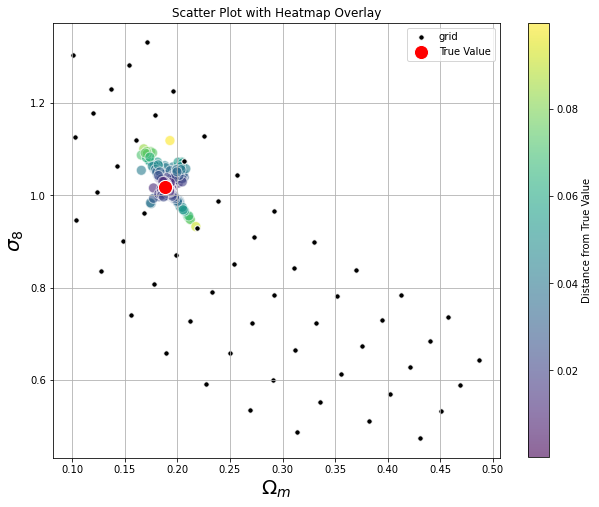

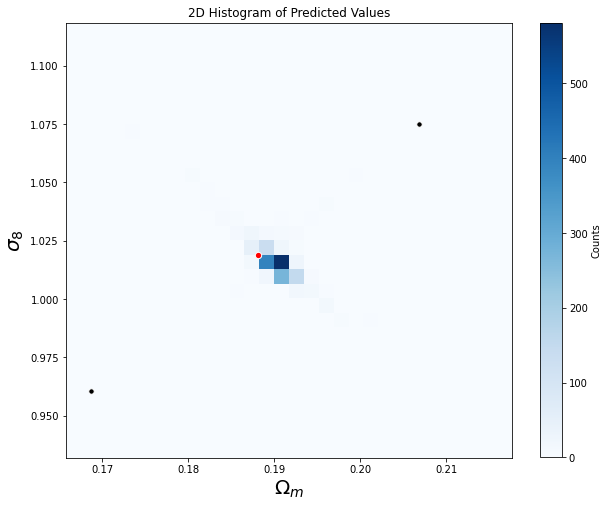

In [30]:
#in the test data every parameter is concurrent 2000 elements
#real epoch epoch * 5 if epoch == 1
epoch = 19
#start = 0
#stop = 2000
start, stop, file_index = start_stop(file_nr = 45)
print(start,stop)
pred_omega_m = pred_omega_m_list[epoch][start:stop]
pred_sigma_8 = pred_sigma_8_list[epoch][start:stop]
true_omega_m = true_omega_m_list[epoch][start:stop][0]
#print(true_omega_m_list[epoch])
true_sigma_8 = true_sigma_8_list[epoch][start:stop][0]

distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pred_omega_m, pred_sigma_8, c=distances, cmap='viridis', s=100, alpha=0.6, edgecolor='w')

# Add color bar to show the distance scale
cbar = plt.colorbar(scatter)
cbar.set_label('Distance from True Value')

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Plot the true value point
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=200, label='True Value', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 
#plt.xlim(0.05, 0.5)  # Adjust the limits according to your data
#plt.ylim(0.4, 1.4) 
plt.title('Scatter Plot with Heatmap Overlay')
plt.legend()
plt.grid(True)



# Show the plot
plt.show()

# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[30, 30], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')
#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

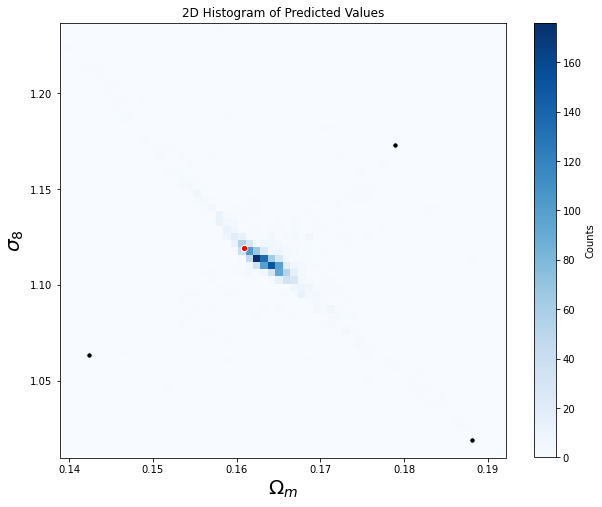

In [27]:
# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.cla()
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')

plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

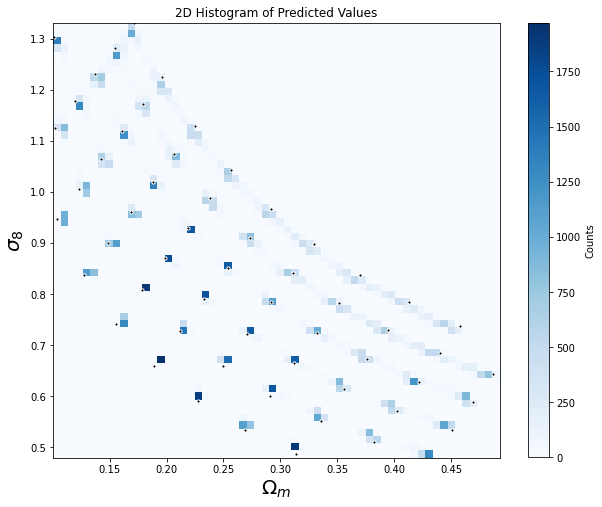

In [31]:
# Create 2D histogram
x = pred_omega_m_list[epoch]
y = pred_sigma_8_list[epoch]
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=10, label='grid', edgecolor='w')

# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)



plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

Processing files: 57it [00:00, 512.19it/s]


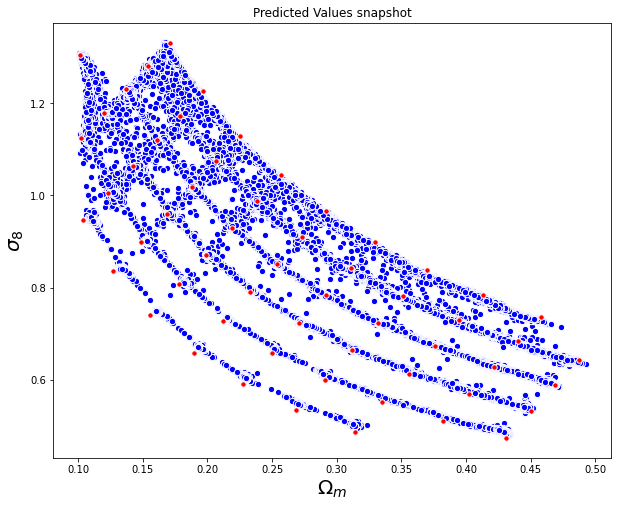

In [32]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


#in the test data every parameter is concurrent 2000 elements
#epoch = 1
pred_omega_m = pred_omega_m_list[epoch]
pred_sigma_8 = pred_sigma_8_list[epoch]


plt.figure(figsize=(10, 8))


truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Add color bar to show scale
plt.scatter(pred_omega_m, pred_sigma_8, c='blue', s=40, label='True Value', edgecolor='w')
plt.scatter(grid_omega_m, grid_sigma_8, c='red', s=30, label='grid', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('Predicted Values snapshot')

# Show plot
plt.show()

In [33]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
#in the test data every parameter is concurrent 2000 elements
start, stop, file_index = start_stop(file_nr = 8)
# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2
true_omega_m = true_omega_m_list[epoch][0]
true_sigma_8 = true_sigma_8_list[epoch][0]

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    pred_omega_m = parameter1_data[frame][start:stop]
    pred_sigma_8 = parameter2_data[frame][start:stop]
    true_omega_m = true_omega_m_list[frame][start:stop][0]
    true_sigma_8 = true_sigma_8_list[frame][start:stop][0]
    distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)
    
    #print(distances.shape)
    
    ax.clear()
    ax.set_xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
    ax.set_ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2)  # Adjust the limits according to your data
    ax.set_title(f"Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel('Omega_m')
    ax.set_ylabel('sigma_8')
    
    
    # Plot scatter points for the current step
    sns.scatterplot(x=pred_omega_m, y=pred_sigma_8, hue = distances ,ax=ax)
    #sns.heatmap(distances, ax=ax, cmap="viridis", cbar=True, alpha=0.6, annot=True)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="black", marker="o", s= 15)
    sns.scatterplot(x=true_omega_m_list[frame][start:stop], y=true_sigma_8_list[frame][start:stop] , ax=ax, color="red", marker="o", s= 30)
    
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.text(0.65, 0.95,f'True: omega_m: {true_omega_m:.2f}, sigma_8: {true_sigma_8:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')
plt.show()

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + "one_param_mse" + ".gif", writer='imagemagick')


Processing files: 57it [00:00, 583.36it/s]
